152022001 - Muhammad Ikhsan

In [10]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Dataset : https://www.kaggle.com/datasets/shivamkushwaha/bbc-full-text-document-classification

Kalsifikasi Jenis Topik Beritas Menggunakna Model / Arsitektur Dari ALBERT ( )

In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from transformers import AlbertTokenizer, AlbertModel

# Load Dataset
def load_dataset(path):
    texts, labels = [], []
    class_names = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]
    for class_name in class_names:
        class_path = os.path.join(path, class_name)
        for filename in os.listdir(class_path):
            if filename.endswith(".txt"):
                file_path = os.path.join(class_path, filename)
                try:
                    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                        texts.append(f.read())
                        labels.append(class_name)
                except Exception as e:
                    print(f"Gagal membaca file {file_path}: {e}")
    return texts, labels

# Plotting
def plot_train_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_acc'], label='Akurasi (Training)')
    plt.plot(history['val_acc'], label='Akurasi (Validation)')
    plt.xlabel('Epoch'); plt.ylabel('Akurasi'); plt.legend(); plt.title('Akurasi Model')
    plt.subplot(1, 2, 2)
    plt.plot(history['train_loss'], label='Loss (Training)')
    plt.plot(history['val_loss'], label='Loss (Validation)')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss Model')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label'); plt.ylabel('True Label'); plt.title('Confusion Matrix')
    plt.show()

# Encoding Text
def encoded_texts(tokenizer, texts, max_len):
    input_ids, attention_masks = [], []
    for text in texts:
        encoded = tokenizer.encode_plus(
            text, add_special_tokens=True, max_length=max_len,
            padding='max_length', truncation=True, return_tensors='pt'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return (torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0))

Custom Model Base Albert

In [12]:
class CustomAlbertClassifier(nn.Module):
    def __init__(self, model_name, num_classes, dropout_rate=0.3):
        super(CustomAlbertClassifier, self).__init__()

        # Konfigurasi Neuron
        neuron1 = 256
        neuron2 = 128
        neuron3 = 64
        self.dropout = nn.Dropout(dropout_rate)

        # Input Layer (ekstraksi fitur)
        self.albert = AlbertModel.from_pretrained(model_name)

        # Hidden Layer 1
        self.hidden1 = nn.Linear(self.albert.config.hidden_size, neuron1)
        self.aktivasi1 = nn.ReLU()

        # Hidden Layer 2
        self.hidden2 = nn.Linear(neuron1, neuron2)
        self.aktivasi2 = nn.ReLU()

        # Hidden Layer 3
        self.hidden3 = nn.Linear(neuron2, neuron3)
        self.aktivasi3 = nn.ReLU()

        # Output Layer
        self.output_layer = nn.Linear(neuron3, num_classes)

    # Progress Pelatihan forward dan backward
    def forward(self, input_ids, attention_mask):
        # Input Layer (ALBERT)
        outputs = self.albert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output

        x = self.dropout(pooled_output)

        # Hidden Layers
        x = self.aktivasi1(self.hidden1(x))
        x = self.aktivasi2(self.hidden2(x))
        x = self.aktivasi3(self.hidden3(x))

        # Output
        logits = self.output_layer(x)

        return logits

Pelatihan Model

Epoch 1/0 | Train Loss: 1.5143 | Train Acc: 0.5562 | Val Loss: 1.3576 | Val Acc: 0.7978
Epoch 2/1 | Train Loss: 1.2209 | Train Acc: 0.8067 | Val Loss: 1.0773 | Val Acc: 0.9551
Epoch 3/2 | Train Loss: 0.9315 | Train Acc: 0.9663 | Val Loss: 0.7746 | Val Acc: 0.9551
Epoch 4/3 | Train Loss: 0.6172 | Train Acc: 0.9860 | Val Loss: 0.4803 | Val Acc: 0.9753
Epoch 5/4 | Train Loss: 0.3859 | Train Acc: 0.9837 | Val Loss: 0.2990 | Val Acc: 0.9775
Epoch 6/5 | Train Loss: 0.2091 | Train Acc: 0.9882 | Val Loss: 0.2349 | Val Acc: 0.9551
Epoch 7/6 | Train Loss: 0.1125 | Train Acc: 0.9904 | Val Loss: 0.1238 | Val Acc: 0.9820
Epoch 8/7 | Train Loss: 0.0849 | Train Acc: 0.9899 | Val Loss: 0.2149 | Val Acc: 0.9551
Epoch 9/8 | Train Loss: 0.0761 | Train Acc: 0.9882 | Val Loss: 0.1857 | Val Acc: 0.9596
Epoch 10/9 | Train Loss: 0.0584 | Train Acc: 0.9921 | Val Loss: 0.1940 | Val Acc: 0.9618
--- Pelatihan Selesai ---


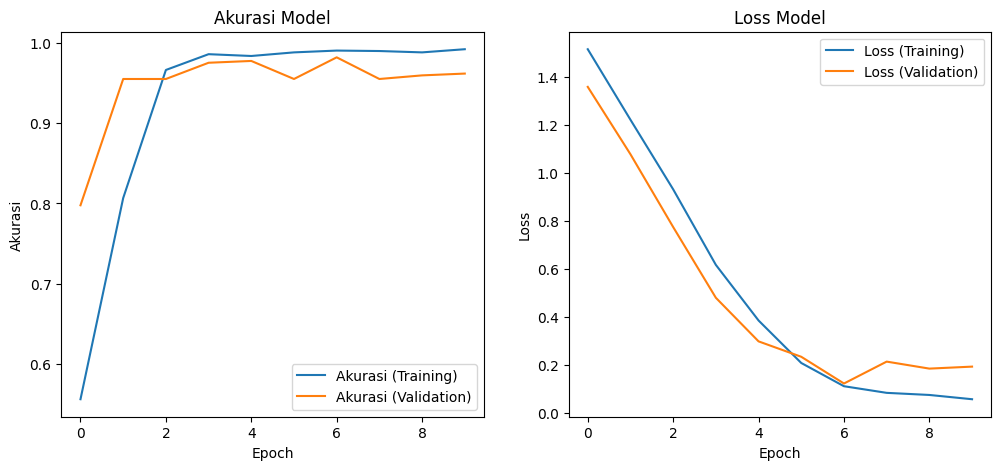

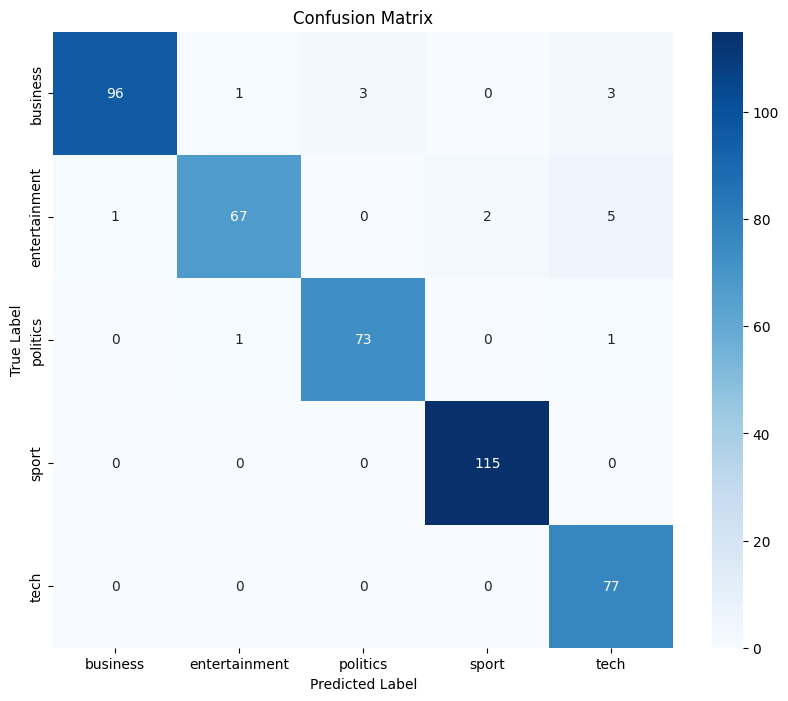


Laporan Klasifikasi:
                precision    recall  f1-score   support

     business       0.99      0.93      0.96       103
entertainment       0.97      0.89      0.93        75
     politics       0.96      0.97      0.97        75
        sport       0.98      1.00      0.99       115
         tech       0.90      1.00      0.94        77

     accuracy                           0.96       445
    macro avg       0.96      0.96      0.96       445
 weighted avg       0.96      0.96      0.96       445


--- Contoh Prediksi ---

Berita: The government announced a new economic policy to boost the stock market.
Prediksi Topik: BUSINESS

Berita: A new smartphone with a revolutionary camera system was unveiled today.
Prediksi Topik: TECH

Berita: The national football team won the championship after a thrilling final match.
Prediksi Topik: SPORT


In [14]:
# Config
path = '/content/drive/MyDrive/topic_bbc'
model_name = 'albert-base-v2'
batch_size = 32
epoch = 10
max_len = 128
learning_rate = 2e-5
dropout_rate = 0.04
contoh_berita = [
    "The government announced a new economic policy to boost the stock market.",
    "A new smartphone with a revolutionary camera system was unveiled today.",
    "The national football team won the championship after a thrilling final match."
]

# Load Dataset
texts, labels = load_dataset(path)

# Encoding Label
label_encoder = LabelEncoder()
label_encoded = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)

# Split Dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, label_encoded, test_size=0.2, random_state=42)

# Tokenisasi
tokenizer = AlbertTokenizer.from_pretrained(model_name)
train_input, train_mask = encoded_texts(tokenizer, train_texts, max_len)
val_input, val_mask = encoded_texts(tokenizer, val_texts, max_len)
train_label = torch.tensor(train_labels)
val_label = torch.tensor(val_labels)

# Data Loader
train_data = TensorDataset(train_input, train_mask, train_label)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
val_data = TensorDataset(val_input, val_mask, val_label)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Config Model
model = CustomAlbertClassifier(
    model_name,
    num_classes=num_classes,
    dropout_rate=dropout_rate
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Pelatihan
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

for epoch in range(epoch):
    model.train() # Set model ke mode train
    total_train_loss, correct_train_preds = 0, 0

    for batch in train_dataloader:
        b_input_ids, b_input_mask, b_labels = [b.to(device) for b in batch]
        model.zero_grad()

        logits = model(b_input_ids, attention_mask=b_input_mask)
        loss = criterion(logits, b_labels)

        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        preds = torch.argmax(logits, dim=1).flatten()
        correct_train_preds += torch.sum(preds == b_labels)

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_acc = correct_train_preds.double() / len(train_data)
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(train_acc.item())

    # Validasi
    model.eval() # Set model ke mode evaluasi
    total_val_loss, correct_val_preds = 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in val_dataloader:
            b_input_ids, b_input_mask, b_labels = [b.to(device) for b in batch]
            logits = model(b_input_ids, attention_mask=b_input_mask)
            loss = criterion(logits, b_labels)
            total_val_loss += loss.item()

            preds = torch.argmax(logits, dim=1).flatten()
            correct_val_preds += torch.sum(preds == b_labels)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(b_labels.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_dataloader)
    val_acc = correct_val_preds.double() / len(val_data)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(val_acc.item())

    print(f"Epoch {epoch+1}/{epoch} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")

print("--- Pelatihan Selesai ---")
plot_train_history(history)
plot_confusion_matrix(all_labels, all_preds, label_encoder.classes_)
print("\nLaporan Klasifikasi:\n", classification_report(all_labels, all_preds, target_names=label_encoder.classes_))

print("\n--- Contoh Prediksi ---")
encoded_contoh = tokenizer.batch_encode_plus(
    contoh_berita, add_special_tokens=True, max_length=max_len, padding='max_length',
    truncation=True, return_attention_mask=True, return_tensors='pt'
)
input_ids = encoded_contoh['input_ids'].to(device)
attention_mask = encoded_contoh['attention_mask'].to(device)

with torch.no_grad():
    logits = model(input_ids, attention_mask=attention_mask)

prediksi_kelas = torch.argmax(logits, dim=1).cpu().numpy()
prediksi_label = label_encoder.inverse_transform(prediksi_kelas)

for text, label in zip(contoh_berita, prediksi_label):
    print(f"\nBerita: {text}\nPrediksi Topik: {label.upper()}")

